In [41]:
import pandas as pd
import numpy as np
import pymysql
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

In [42]:
# Get connection
def get_conn():
    return 'mysql+pymysql://%s:%s@%s:%s/%s?charset=utf8mb4&local_infile=1' % ('sa', 'sa', 'DESKTOP-6CIS8BB', '3306', 'olist_db')

In [43]:
# Set MySQL engine connection
def engine_connect():
    return create_engine(get_conn(), pool_size=10, max_overflow=20)

In [44]:
def get_data(query):
  try:
    connection=engine_connect()
    return pd.read_sql(query, connection)
  except SQLAlchemyError as e:
    raise e

In [70]:
# Get Total Sales by Period
df_sales = get_data("""SELECT year, month, SUM(price) as Sales FROM olist_db.f_sales as sales
                INNER JOIN olist_db.d_day as d_day on d_day.day_id = sales.day_id
                INNER JOIN olist_db.d_month as d_month on d_month.month_id = sales.month_id
                INNER JOIN olist_db.d_year as d_year on d_year.year_id = sales.year_id
                Group by year, month;""")
df_sales['Date'] = pd.to_datetime(df_sales.year*100+df_sales.month,format='%Y%m')
df_sales = df_sales[['Sales', 'Date']].sort_values(by=['Date'])
df_sales.to_csv('df_sales.csv', index=False)
df_sales.head(10)

,Sales,Date
20,51161.32,2016-10-01
22,10.90,2016-12-01
17,123277.55,2017-01-01
4,261801.62,2017-02-01
14,392147.91,2017-03-01
1,388874.78,2017-04-01
5,546355.29,2017-05-01
18,455554.17,2017-06-01
19,524705.07,2017-07-01
12,599876.06,2017-08-01


In [46]:
# Plot monthly sales
plot_data = [
    go.Scatter(
        x=df_sales['Date'],
        y=df_sales['Sales'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [67]:
# Calculate difference in sales month over month with previous
def get_diff_prev_sales(data):
    # Create a new dataframe to model the difference
    df_diff = df_sales.copy()
    # Add previous sales to the next row
    df_diff['prev_sales'] = df_diff['Sales'].shift(1)
    # Drop the null values and calculate the difference
    df_diff = df_diff.dropna()
    df_diff['sales_diff'] = (df_diff['Sales'] - df_diff['prev_sales'])
    return df_diff

In [56]:
# Calculate difference in sales month over month without diff
def get_diff(data):
    data['sales_diff'] = data.Sales.diff()    
    data = data.dropna()      
    return data

In [69]:
stationary_df = get_diff_prev_sales(df_sales)
# stationary_df = get_diff(df_sales)
stationary_df.head(10)
stationary_df.to_csv('stationary_df.csv', index=False)

In [60]:
# Plot sales diff
plot_data = [
    go.Scatter(
        x=stationary_df['Date'],
        y=stationary_df['sales_diff'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [61]:
def generate_arima_data(data):
    dt_data = data.set_index('Date').drop('Sales', axis=1)        
    dt_data.dropna(axis=0)     
    return dt_data

In [62]:
arima_data = generate_arima_data(stationary_df)
arima_data.head(10)

,sales_diff
Date,
2016-12-01,-51150.42
2017-01-01,123266.65
2017-02-01,138524.07
2017-03-01,130346.29
2017-04-01,-3273.13
2017-05-01,157480.51
2017-06-01,-90801.12
2017-07-01,69150.90
2017-08-01,75170.99


In [65]:
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(stationary_df.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    return sar, data, pred_df



C:\Users\Edward\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\Edward\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\Edward\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\Edward\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-pack

,sales_diff,forecast
Date,,
2016-12-01,-51150.42,NaN
2017-01-01,123266.65,NaN
2017-02-01,138524.07,NaN
2017-03-01,130346.29,NaN
2017-04-01,-3273.13,NaN
2017-05-01,157480.51,NaN
2017-06-01,-90801.12,NaN
2017-07-01,69150.90,NaN
2017-08-01,75170.99,NaN


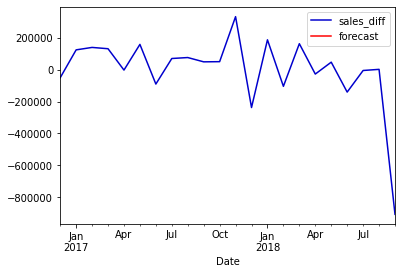

In [66]:
ts_data = arima_data
ts_data.index = pd.to_datetime(ts_data.index)
sar, ts_data, predictions = sarimax_model(ts_data)
ts_data.head(10)
# sar.plot_diagnostics(figsize=(10, 8))